## The goal of this model is to predict airplane arrival delay 1 week in advance

In [18]:
import pandas as pd
import datetime
import psycopg2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Connect to database with psycopg2
connection = psycopg2.connect(
    host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com",
    database="mid_term_project",
    user="lhl_student",
    password="lhl_student",
    port=5432
)

In [3]:
#target variable is arr_delay. positive value means delay, negative value means early departure
df_flights = pd.read_sql_query('SELECT fl_date, mkt_carrier, origin, dest, crs_dep_time, crs_arr_time, crs_elapsed_time, arr_delay, distance, dest_city_name FROM flights ORDER BY RANDOM() LIMIT 60000;', connection)
df_flights.head()

,fl_date,mkt_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,arr_delay,distance,dest_city_name
0,2018-01-26,VX,JFK,LAS,750,1051,361.0,-41.0,2248.0,"Las Vegas, NV"
1,2018-08-13,AA,ORD,MKE,850,937,47.0,-5.0,67.0,"Milwaukee, WI"
2,2019-07-07,DL,ICT,ATL,1714,2030,136.0,-2.0,782.0,"Atlanta, GA"
3,2019-08-09,AA,BOI,DFW,710,1120,190.0,-19.0,1272.0,"Dallas/Fort Worth, TX"
4,2019-02-14,AA,MEM,ORD,518,710,112.0,NaN,491.0,"Chicago, IL"


## Data Cleaning

In [4]:
#the only nulls are in arr_delay, which we assume is on time flight
df_flights.isnull().sum()

fl_date                0
mkt_carrier            0
origin                 0
dest                   0
crs_dep_time           0
crs_arr_time           0
crs_elapsed_time       0
arr_delay           1152
distance               0
dest_city_name         0
dtype: int64

In [5]:
#only concern is elapsed_time has negative values. everything else seems realistic
df_flights.describe()

,crs_dep_time,crs_arr_time,crs_elapsed_time,arr_delay,distance
count,60000.000000,60000.000000,60000.000000,58848.000000,60000.000000
mean,1330.910417,1487.182567,138.030483,5.544521,768.249067
std,488.708146,515.737443,71.874475,52.072603,584.051890
min,5.000000,1.000000,20.000000,-66.000000,31.000000
25%,915.000000,1100.000000,87.000000,-15.000000,342.000000
50%,1325.000000,1516.000000,120.000000,-6.000000,605.000000
75%,1735.000000,1918.000000,168.000000,8.000000,1005.000000
max,2359.000000,2359.000000,1609.000000,2050.000000,5095.000000


In [6]:
#how many negative elapsed time
df_flights[df_flights['crs_elapsed_time']<0]

,fl_date,mkt_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,arr_delay,distance,dest_city_name


In [7]:
#since it is just one outlier we can drop it
df_flights = df_flights[df_flights['crs_elapsed_time']>0]

## Exploratory Data Analysis

In [16]:
#try to identify any relationships between delay and any features.
#extract some categorical variables first such as month, day of week etc
df_delay = pd.read_sql_query('SELECT fl_date, mkt_carrier,mkt_carrier_fl_num,tail_num, origin, dest, crs_dep_time, crs_elapsed_time, distance,arr_delay,dep_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay  FROM flights ORDER BY RANDOM() LIMIT 60000;', connection)
df_delay['total_delay'] = df_delay['dep_delay'] + df_delay['arr_delay'] + df_delay['carrier_delay'] + df_delay['weather_delay'] + df_delay['nas_delay'] + df_delay['security_delay'] + df_delay['late_aircraft_delay']
df_delay = df_delay.drop(columns=['arr_delay','dep_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'])
df_delay['month'] = df_delay['fl_date'].apply(lambda x: int(x.split('-')[1]))
df_delay['day_of_week'] = df_delay['fl_date'].apply(get_day_of_week)
df_delay['total_delay'] = df_delay['total_delay'].fillna(0)
df_delay['dep_time'] = df_delay['crs_dep_time'].apply(lambda x: x//100)
df_delay.head()

,fl_date,mkt_carrier,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,crs_elapsed_time,distance,total_delay,month,day_of_week,dep_time
0,2019-05-14,WN,324,N8557Q,PHL,FLL,735,170.0,992.0,0.0,5,1,7
1,2019-07-31,WN,2717,N953WN,LAX,ELP,2150,110.0,715.0,110.0,7,2,21
2,2018-05-01,DL,1302,N985AT,ATL,SDF,1053,80.0,321.0,0.0,5,1,10
3,2019-05-17,AS,3491,N176SY,FAT,SEA,1915,140.0,748.0,0.0,5,4,19
4,2019-11-08,UA,692,N73283,MCI,ORD,1523,95.0,403.0,0.0,11,4,15


Text(0, 0.5, 'Mean Delay')

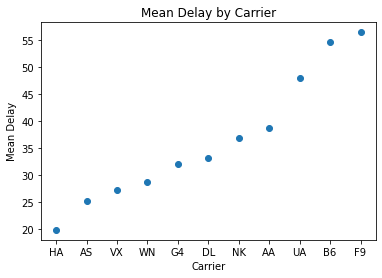

In [19]:
#Significant relationship. some Airlines have longer mean delay
a = df_delay[['mkt_carrier','total_delay']].groupby(df_delay['mkt_carrier']).mean().sort_values(by='total_delay')
plt.scatter(a.index,a.values)
plt.title('Mean Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Mean Delay')

Text(0, 0.5, 'Mean Delay')

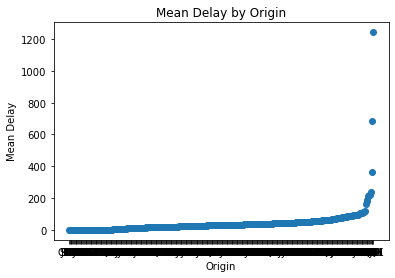

In [20]:
#origin airport probably not significant. seems like outliers
b = df_delay[['origin','total_delay']].groupby(df_delay['origin']).mean().sort_values(by='total_delay')
plt.scatter(b.index,b.values)
plt.title('Mean Delay by Origin')
plt.xlabel('Origin')
plt.ylabel('Mean Delay')

Text(0, 0.5, 'Mean Delay')

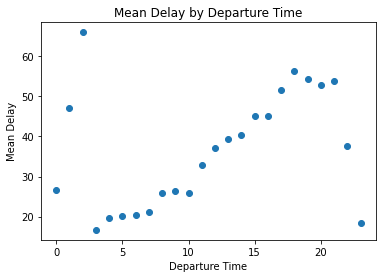

In [23]:
#significant relationship between departure time of day and mean delay
d = df_delay[['dep_time','total_delay']].groupby(df_delay['dep_time']).mean().sort_values(by='total_delay')
plt.scatter(d['dep_time'],d['total_delay'])
plt.title('Mean Delay by Departure Time')
plt.xlabel('Departure Time')
plt.ylabel('Mean Delay')

(-51.900000000000006, 500.0)

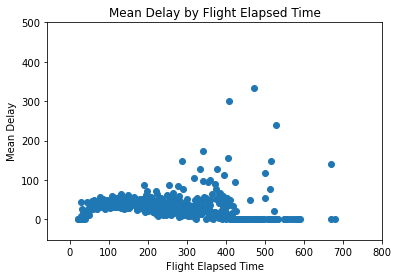

In [27]:
#insignificant
e = df_delay[['crs_elapsed_time','total_delay']].groupby(df_delay['crs_elapsed_time']).mean().sort_values(by='total_delay')
plt.scatter(e['crs_elapsed_time'],e['total_delay'])
plt.title('Mean Delay by Flight Elapsed Time')
plt.xlabel('Flight Elapsed Time')
plt.ylabel('Mean Delay')
plt.xlim(right=800)
plt.ylim(top=500)

Text(0, 0.5, 'Mean Delay')

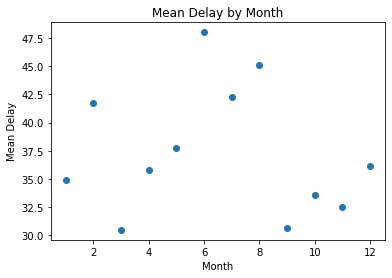

In [28]:
#seems significant by season. ie summer, winter
g = df_delay[['month','total_delay']].groupby(df_delay['month']).mean().sort_values(by='total_delay')
plt.scatter(g['month'],g['total_delay'])
plt.title('Mean Delay by Month')
plt.xlabel('Month')
plt.ylabel('Mean Delay')

Text(0, 0.5, 'Mean Delay')

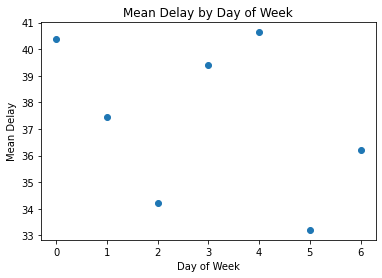

In [29]:
#seems significant by weekday/weekend
h = df_delay[['day_of_week','total_delay']].groupby(df_delay['day_of_week']).mean().sort_values(by='total_delay')
plt.scatter(h['day_of_week'],h['total_delay'])
plt.title('Mean Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Mean Delay')

#### Now that some relationships have been identified, they will be engineered into features to hopefully boost our models accuracy

## Feature Engineering

In [12]:
#getter functions
def get_day_of_week(x):
    a = int(x.split('-')[0])
    b = int(x.split('-')[1])
    c = int(x.split('-')[2])
    dt = datetime.datetime(a,b,c)
    return dt.weekday()

def get_flight_length(x):
    if x < 180:
        return 'short'
    elif x > 360:
        return 'long'
    else:
        return 'medium'
    
def get_traffic(x):
    if x < 700:
        return 'quiet'
    elif x > 4200:
        return 'busy'
    else:
        return 'moderate'
    
def get_arr_delay(x):
    if x > 0:
        return 'delay'
    elif x == 0:
        return 'on time'
    else:
        return 'early'
    
def get_season(x):
    if x > 5 and x < 9:
        return 'summer'
    elif x > 8 and x < 12:
        return 'fall'
    elif x < 6 and x > 2:
        return 'spring'
    else:
        return 'winter'

def get_dep_time_cat(x):
    if x > 1 and x < 10:
        return 'morning'
    elif x > 9 and x < 18:
        return 'afternoon'
    else:
        return 'evening'

In [35]:
df_traffic = pd.read_sql_query('SELECT origin, dest, passengers, month FROM passengers ORDER BY RANDOM() LIMIT 60000;', connection)
df_traffic.head()

,origin,dest,passengers,month
0,BNA,SFO,936.0,10
1,SJC,DEN,1758.0,2
2,MCO,LGW,2975.0,12
3,ORD,LHR,11081.0,11
4,STL,DEN,4332.0,10


In [38]:
#create features based on bining into categorical variables
df_features = df_flights.copy()[['mkt_carrier','origin','dest','arr_delay','distance']]
df_features['month'] = df_flights['fl_date'].apply(lambda x: int(x.split('-')[1]))
df_features['day_of_week'] = df_flights['fl_date'].apply(get_day_of_week)
df_features['departure_time'] = df_flights['crs_dep_time'].apply(lambda x: x//100)
df_features['flight_length'] = df_flights['crs_elapsed_time'].apply(get_flight_length)
df_features = pd.merge(df_features,df_traffic, on=['origin','dest','month'])
df_features['passengers'] = df_features['passengers'].replace(0, np.nan).dropna(axis=0, how='any')
df_features['airport_traffic'] = df_features['passengers'].apply(get_traffic)
df_features = df_features.drop(columns=['passengers'])
df_features['distance'] = df_features['distance'].apply(lambda x: x//10)
df_features['arr_delay'] = df_features['arr_delay'].apply(get_arr_delay)
df_features['weekday_weekend'] = df_features['day_of_week'].apply(lambda x: 'weekend' if x > 4 else 'weekday')
df_features['season'] = df_features['month'].apply(get_season)
df_features['departure_time_cat'] = df_features['departure_time'].apply(get_dep_time_cat)
df_features.head()

,mkt_carrier,origin,dest,arr_delay,distance,month,day_of_week,departure_time,flight_length,airport_traffic,weekday_weekend,season,departure_time_cat
0,AA,ORD,MCO,early,100.0,12,0,11,short,quiet,weekday,winter,afternoon
1,NK,ORD,MCO,early,100.0,12,5,11,short,quiet,weekend,winter,afternoon
2,AA,ORD,MCO,delay,100.0,12,0,7,short,quiet,weekday,winter,morning
3,NK,ORD,MCO,early,100.0,12,4,11,short,quiet,weekday,winter,afternoon
4,UA,ORD,MCO,early,100.0,12,2,11,short,quiet,weekday,winter,afternoon


## Exploratory Data Analysis

In [ ]:
s